## Hybrid Attempt

>>> INIZIO PIPELINE IBRIDA ANALISI GOOGLE TRENDS E PCA <<<

--- Inizio Caricamento Dati ---
Dati caricati con successo per 'Termini_Diretti' da 'Gruppo1(4).csv'
Dati caricati con successo per 'Alimentari' da 'Gruppo2(4).csv'
Dati caricati con successo per 'Energia' da 'Gruppo3(4).csv'
Dati caricati con successo per 'Abitazione' da 'Gruppo4(4).csv'
Dati caricati con successo per 'Trasporti' da 'Gruppo5(4).csv'
Dati caricati con successo per 'Politiche_Economiche' da 'Gruppo6(4).csv'
Dati caricati con successo per 'Aspettative_Consumatori' da 'Gruppo7(4).csv'
Dati caricati con successo per 'Sanita' da 'Gruppo8(4).csv'
Dati caricati con successo per 'Ricreazione' da 'Gruppo9(4).csv'
--- Fine Caricamento Dati ---

--- Inizio Identificazione Periodo Comune ---
Info (Periodo Comune): Periodo comune identificato: da 2004-01-01 a 2024-12-01
--- Fine Identificazione Periodo Comune ---

--- Inizio Combinazione Dati ---
Info (Combinazione): DataFrame combinato inizializzato con indice da 2004-01-

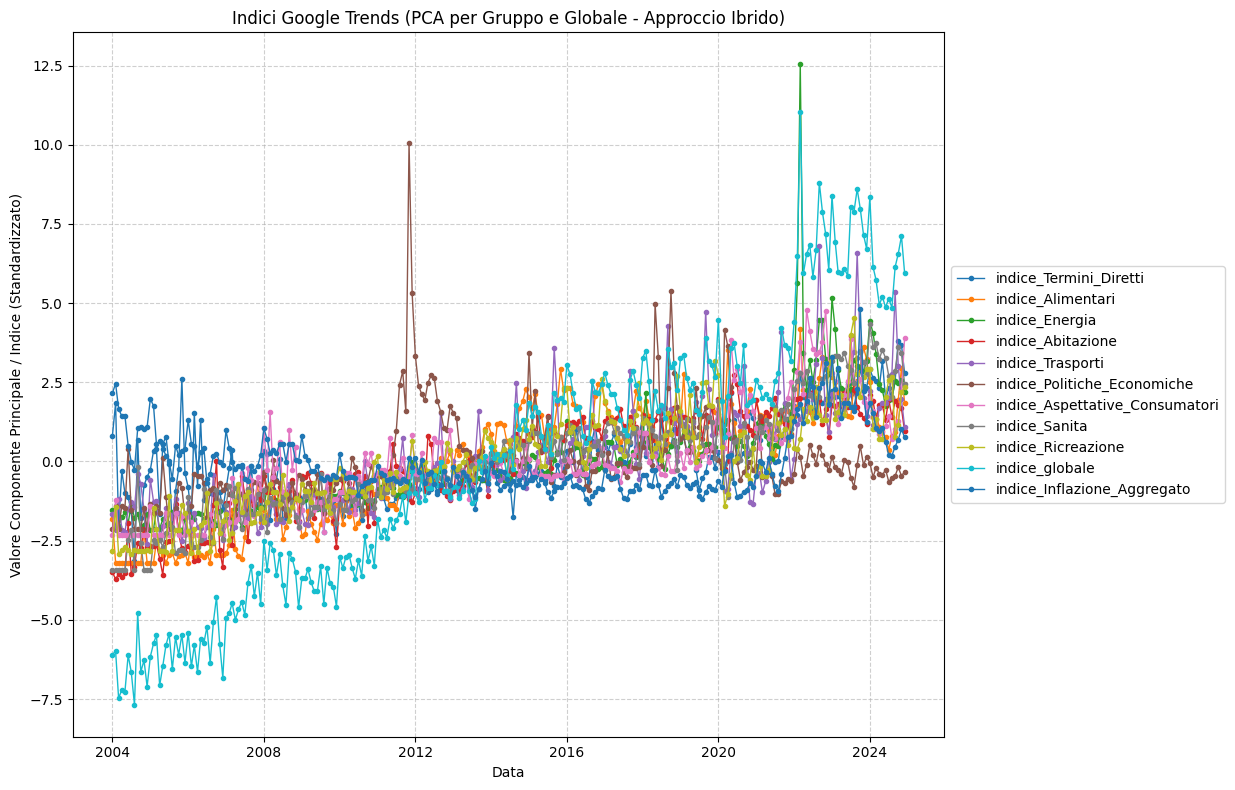

Info (Vis/Salvataggio): Indici salvati con successo in '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_google_trends_ibrido.csv'
--- Fine Visualizzazione e Salvataggio Indici ---


>>> PIPELINE IBRIDA COMPLETATA <<<


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- CONFIGURAZIONE ---
PATH_DATI = "/Users/tommaso/Desktop/tesi-inflation-gt/Official_4"
PATH_SALVATAGGIO_INDICI = '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_google_trends_ibrido.csv'

NOMI_GRUPPI_DICT = {
    "Gruppo1(4)": "Termini_Diretti",
    "Gruppo2(4)": "Alimentari",
    "Gruppo3(4)": "Energia",
    "Gruppo4(4)": "Abitazione",
    "Gruppo5(4)": "Trasporti",
    "Gruppo6(4)": "Politiche_Economiche",
    "Gruppo7(4)": "Aspettative_Consumatori",
    "Gruppo8(4)": "Sanita",
    "Gruppo9(4)": "Ricreazione"
}

# --- 1. CARICAMENTO DATI ---
def carica_dati_gt(path_csv, nomi_file_mappati):
    """
    Carica i dati di Google Trends da file CSV multipli.
    Normalizza i nomi delle colonne, imposta l'indice temporale.
    """
    dati_caricati_per_gruppo = {}
    print("--- Inizio Caricamento Dati ---")
    for nome_file_csv, nome_gruppo_logico in nomi_file_mappati.items():
        file_path = os.path.join(path_csv, f"{nome_file_csv}.csv")
        try:
            df = pd.read_csv(file_path, skiprows=2, header=0)
            df.columns = [str(col).strip().lower() for col in df.columns]
            colonna_data = None
            for possible_date_col in ['mese', 'month', 'settimana', 'week', 'giorno', 'day']:
                if possible_date_col in df.columns:
                    colonna_data = possible_date_col
                    break
            if colonna_data is None:
                raise ValueError(f"Nessuna colonna data standard ('mese', 'settimana', 'giorno', etc.) trovata in {nome_file_csv}")
            if colonna_data != 'mese':
                print(f"Info: Trovata colonna data '{colonna_data}' in {nome_file_csv}. Sarà usata come indice.")
            df.set_index(colonna_data, inplace=True)
            try:
                df.index = pd.to_datetime(df.index)
            except Exception as e_date:
                try:
                    df.index = pd.to_datetime(df.index, format="%Y-%m")
                except Exception:
                    raise e_date
            dati_caricati_per_gruppo[nome_gruppo_logico] = df
            print(f"Dati caricati con successo per '{nome_gruppo_logico}' da '{nome_file_csv}.csv'")
        except Exception as e:
            print(f"ERRORE nel caricamento di '{nome_file_csv}.csv': {e}")
    print("--- Fine Caricamento Dati ---\n")
    return dati_caricati_per_gruppo


# --- 2. IDENTIFICAZIONE PERIODO COMUNE ---
def trova_periodo_comune(dati_dict_input):
    """
    Trova il periodo temporale comune (massimo inizio, minimo fine) tra tutti i DataFrame nel dizionario.
    """
    print("--- Inizio Identificazione Periodo Comune ---")
    if not dati_dict_input:
        print("Attenzione (Periodo Comune): Dizionario gruppi vuoto.")
        return None, None
    date_inizio_valide = []
    date_fine_valide = []
    for gruppo, df in dati_dict_input.items():
        if not df.empty and isinstance(df.index, pd.DatetimeIndex):
            date_inizio_valide.append(df.index.min())
            date_fine_valide.append(df.index.max())
        else:
            print(f"Attenzione (Periodo Comune): DataFrame per gruppo '{gruppo}' vuoto o con indice non Datetime. Escluso dal calcolo periodo.")
    if not date_inizio_valide or not date_fine_valide:
        print("Attenzione (Periodo Comune): Nessuna data valida trovata. Impossibile determinare periodo comune.")
        return None, None
    inizio_comune_calc = max(date_inizio_valide)
    fine_comune_calc = min(date_fine_valide)
    if inizio_comune_calc > fine_comune_calc:
        print(f"Attenzione (Periodo Comune): Nessun periodo comune valido trovato (max inizio: {inizio_comune_calc}, min fine: {fine_comune_calc}).")
        return None, None
    elif inizio_comune_calc == fine_comune_calc:
        print(f"Info (Periodo Comune): Periodo comune consiste in un solo punto dati: {inizio_comune_calc}")
    else:
        print(f"Info (Periodo Comune): Periodo comune identificato: da {inizio_comune_calc.strftime('%Y-%m-%d')} a {fine_comune_calc.strftime('%Y-%m-%d')}")
    print("--- Fine Identificazione Periodo Comune ---\n")
    return inizio_comune_calc, fine_comune_calc


# --- 3. COMBINAZIONE DATI SU PERIODO COMUNE ---
def combina_dati_su_periodo_comune(dati_dict_input, inizio_dt, fine_dt):
    """
    Filtra i dati per il periodo comune e li combina in un unico DataFrame.
    Aggiunge un prefisso del nome del gruppo a ciascuna colonna per unicità.
    """
    print("--- Inizio Combinazione Dati ---")
    if inizio_dt is None or fine_dt is None or not dati_dict_input:
        print("Errore (Combinazione): Periodo comune non valido o dati input vuoti. Impossibile combinare.")
        return None

    idx_comune = pd.date_range(start=inizio_dt, end=fine_dt, freq='MS')
    df_combinato_finale = pd.DataFrame(index=idx_comune)
    print(f"Info (Combinazione): DataFrame combinato inizializzato con indice da {inizio_dt.strftime('%Y-%m-%d')} a {fine_dt.strftime('%Y-%m-%d')} ({len(df_combinato_finale)} righe).")

    for nome_gruppo_logico, df_originale in dati_dict_input.items():
        if df_originale.empty or not isinstance(df_originale.index, pd.DatetimeIndex):
            print(f"Info (Combinazione): Gruppo '{nome_gruppo_logico}' vuoto o con indice non valido. Skippato.")
            continue
        df_periodo_gruppo = df_originale[(df_originale.index >= inizio_dt) & (df_originale.index <= fine_dt)]
        if df_periodo_gruppo.empty:
            print(f"Info (Combinazione): Gruppo '{nome_gruppo_logico}' non ha dati nel periodo comune. Skippato.")
            continue
        for col_originale_nome in df_periodo_gruppo.columns:
            nome_colonna_con_prefisso = f"{nome_gruppo_logico}_{col_originale_nome}"
            serie_reindicizzata = df_periodo_gruppo[col_originale_nome].reindex(df_combinato_finale.index)
            df_combinato_finale[nome_colonna_con_prefisso] = serie_reindicizzata
    print(f"Info (Combinazione): DataFrame combinato finale con {df_combinato_finale.shape[0]} righe e {df_combinato_finale.shape[1]} colonne.")
    print("--- Fine Combinazione Dati ---\n")
    return df_combinato_finale


# --- 4. PULIZIA VALORI SPECIFICI DI GOOGLE TRENDS ('<1') ---
def pulisci_valori_gt(df_input):
    """
    Sostituisce i valori testuali come '<1' con 0.5. Converte le colonne in numerico.
    """
    print("--- Inizio Pulizia Valori Google Trends ('<1') ---")
    if df_input is None:
        print("Errore (Pulizia GT): DataFrame input è None.")
        return None
    df_pulito = df_input.copy()
    for col in df_pulito.columns:
        col_as_str = df_pulito[col].astype(str)
        num_sostituzioni = col_as_str.str.contains(r'< ?1').sum()
        if num_sostituzioni > 0:
            # print(f"Info (Pulizia GT): Colonna '{col}': {num_sostituzioni} valori contenenti '<1' saranno sostituiti con 0.5.") # Log opzionale
            df_pulito[col] = df_pulito[col].replace(to_replace=r'< ?1', value=0.5, regex=True)
        df_pulito[col] = pd.to_numeric(df_pulito[col], errors='coerce')
        if df_pulito[col].isnull().any():
            nan_count = df_pulito[col].isnull().sum()
            if num_sostituzioni == 0 and nan_count > 0:
                 print(f"Attenzione (Pulizia GT): Colonna '{col}' contiene {nan_count} NaN dopo conversione, non originati da sostituzione '<1'.")
            # elif num_sostituzioni > 0 and df_pulito[col].isnull().sum() > 0 : # Log opzionale
                 # print(f"Info (Pulizia GT): Colonna '{col}' contiene {nan_count} NaN dopo conversione.")
    print("--- Fine Pulizia Valori Google Trends --- \n")
    return df_pulito


# --- 5. GESTIONE VALORI MANCANTI (NaN) ---
def gestisci_nan(df_input, strategy='fillna', fill_value=0, interpolate_method='linear'):
    """
    Gestisce i valori NaN nel DataFrame secondo una strategia specificata.
    """
    print(f"--- Inizio Gestione NaN (Strategia: {strategy}) ---")
    if df_input is None:
        print("Errore (Gestione NaN): DataFrame input è None.")
        return None
    df_gestito = df_input.copy()
    nan_presenti_prima = df_gestito.isnull().values.any()
    if not nan_presenti_prima:
        print("Info (Gestione NaN): Nessun NaN trovato. Nessuna azione richiesta.")
        print("--- Fine Gestione NaN ---\n")
        return df_gestito
    print(f"Info (Gestione NaN): Trovati NaN. Applico strategia '{strategy}'.")
    if strategy == 'fillna':
        df_gestito = df_gestito.fillna(fill_value)
        # print(f"Info (Gestione NaN): NaN sostituiti con {fill_value}.") # Log opzionale
    elif strategy == 'interpolate':
        df_gestito = df_gestito.interpolate(method=interpolate_method, axis=0)
        if df_gestito.isnull().values.any():
            # print(f"Info (Gestione NaN): NaN rimanenti dopo interpolazione. Riempiti con {fill_value}.") # Log opzionale
            df_gestito = df_gestito.fillna(fill_value)
    # Altre strategie (dropna_rows, dropna_cols) omesse per brevità ma possono essere reinserite se necessario
    else:
        print(f"Attenzione (Gestione NaN): Strategia '{strategy}' non riconosciuta. NaN non gestiti.")
        print("--- Fine Gestione NaN ---\n")
        return df_input
    if df_gestito.isnull().values.any():
        print("Attenzione (Gestione NaN): NaN ancora presenti dopo la gestione. Verifica la strategia e i dati.")
    else:
        print("Info (Gestione NaN): Tutti i NaN sono stati gestiti.")
    print("--- Fine Gestione NaN ---\n")
    return df_gestito


# --- 6. STANDARDIZZAZIONE SERIE (Z-SCORE) ---
def standardizza_serie_temporali(df_input):
    """
    Standardizza le serie temporali (colonne) del DataFrame usando Z-score.
    """
    print("--- Inizio Standardizzazione Serie (Z-score) ---")
    if df_input is None:
        print("Errore (Standardizzazione): DataFrame input è None.")
        return None
    df_std = df_input.copy()
    for col in df_std.columns:
        if not pd.api.types.is_numeric_dtype(df_std[col]):
            print(f"Attenzione (Standardizzazione): Colonna '{col}' non numerica. Skippata.")
            continue
        media = df_std[col].mean()
        std_dev = df_std[col].std()
        if std_dev != 0:
            df_std[col] = (df_std[col] - media) / std_dev
        else:
            df_std[col] = 0
            # print(f"Info (Standardizzazione): Colonna '{col}' ha deviazione standard nulla. Impostata a 0.") # Log opzionale
    print("--- Fine Standardizzazione Serie ---\n")
    return df_std


# --- 7. ESTRAZIONE INDICE INFLAZIONE (STRATEGIA IBRIDA) ---
def estrai_indice_inflazione(df_std_input):
    """
    Estrae tutte le colonne contenenti "inflazione", ne calcola la media (come indice inflazione aggregato),
    e restituisce questo indice e un DataFrame senza queste colonne "inflazione".
    """
    print("--- Inizio Estrazione Indice Inflazione (Strategia Ibrida) ---")
    if df_std_input is None or df_std_input.empty:
        print("Errore (Estrazione Inflazione): DataFrame input è None o vuoto.")
        return None, df_std_input

    colonne_inflazione = [col for col in df_std_input.columns if "inflazione" in col.lower()] # Adattare se il termine chiave è diverso
    
    df_solo_inflazione_series = df_std_input[colonne_inflazione].copy() if colonne_inflazione else None
    
    if df_solo_inflazione_series is None or df_solo_inflazione_series.empty:
        print("Attenzione (Estrazione Inflazione): Nessun termine 'inflazione' trovato. L'indice inflazione sarà None.")
        indice_inflazione_agg = pd.Series(index=df_std_input.index, dtype=float) # Serie di NaN
        df_senza_inflazione_terms = df_std_input.copy()
    else:
        # Calcola l'indice dell'inflazione come media delle serie di inflazione standardizzate
        indice_inflazione_agg = df_solo_inflazione_series.mean(axis=1)
        print(f"Info (Estrazione Inflazione): Creato indice inflazione aggregato da {len(colonne_inflazione)} termini.")
        # for col in colonne_inflazione: print(f"  - {col}") # Log opzionale

        # Crea un DataFrame senza i termini inflazione originali per l'analisi PCA dei gruppi
        df_senza_inflazione_terms = df_std_input.drop(columns=colonne_inflazione, errors='ignore')
        print(f"Info (Estrazione Inflazione): Rimossi termini 'inflazione' dal DataFrame per PCA di gruppo. Rimanenti {df_senza_inflazione_terms.shape[1]} colonne.")
    
    print("--- Fine Estrazione Indice Inflazione ---\n")
    return indice_inflazione_agg, df_senza_inflazione_terms


# --- 8. CREAZIONE INDICI PCA PER GRUPPO (SENZA TERMINI INFLAZIONE) ---
def crea_indici_pca_per_gruppo_ibrido(df_input_senza_infl, nomi_gruppi_mappati):
    """
    Applica PCA a ciascun gruppo (da df_input_senza_infl), escludendo i termini "inflazione" già estratti.
    """
    print("--- Inizio Creazione Indici PCA per Gruppo (Senza Termini Inflazione) ---")
    if df_input_senza_infl is None or df_input_senza_infl.empty:
        print("Errore (PCA Gruppi Ibrido): DataFrame input è None o vuoto.")
        return pd.DataFrame(index=df_input_senza_infl.index if df_input_senza_infl is not None else None)

    indici_pca_df = pd.DataFrame(index=df_input_senza_infl.index)

    for nome_gruppo_logico in nomi_gruppi_mappati.values():
        # Le colonne "inflazione" sono già state rimosse da df_input_senza_infl
        colonne_del_gruppo = [col for col in df_input_senza_infl.columns if col.startswith(f"{nome_gruppo_logico}_")]

        if not colonne_del_gruppo:
            # print(f"Info (PCA Gruppi Ibrido): Nessuna colonna (non-inflazione) per gruppo '{nome_gruppo_logico}'.") # Log opzionale
            indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan
            continue
        
        dati_gruppo_pca = df_input_senza_infl[colonne_del_gruppo].copy()
        dati_gruppo_pca_validi = dati_gruppo_pca.loc[:, dati_gruppo_pca.var() > 1e-9]

        if dati_gruppo_pca_validi.shape[1] >= 1:
            if dati_gruppo_pca_validi.shape[1] == 1:
                # print(f"Info (PCA Gruppi Ibrido): Gruppo '{nome_gruppo_logico}' ha 1 var non-inflazione ('{dati_gruppo_pca_validi.columns[0]}'). Usata direttamente.") # Log opzionale
                indici_pca_df[f'indice_{nome_gruppo_logico}'] = dati_gruppo_pca_validi.iloc[:, 0]
            else:
                pca = PCA(n_components=1)
                try:
                    if dati_gruppo_pca_validi.isnull().values.any():
                        raise ValueError("NaN presenti nei dati del gruppo prima della PCA.")
                    componente = pca.fit_transform(dati_gruppo_pca_validi)
                    indici_pca_df[f'indice_{nome_gruppo_logico}'] = componente.flatten()
                    print(f"\nGruppo '{nome_gruppo_logico}' (Senza Termini Inflazione):")
                    print(f"  Varianza spiegata da PC1: {pca.explained_variance_ratio_[0]:.2%} (su {dati_gruppo_pca_validi.shape[1]} variabili)")
                    print("  Loadings:")
                    for i, col_pca_nome in enumerate(dati_gruppo_pca_validi.columns):
                        print(f"    {col_pca_nome}: {pca.components_[0][i]:.4f}")
                except Exception as e_pca:
                    print(f"ERRORE PCA per gruppo '{nome_gruppo_logico}': {e_pca}")
                    indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan
        else:
            # print(f"Info (PCA Gruppi Ibrido): Gruppo '{nome_gruppo_logico}' non ha var non-inflazione con varianza. Indice non creato.") # Log opzionale
            indici_pca_df[f'indice_{nome_gruppo_logico}'] = np.nan
    print("--- Fine Creazione Indici PCA per Gruppo (Senza Termini Inflazione) ---\n")
    return indici_pca_df


# --- 9. CREAZIONE INDICE PCA GLOBALE (CON INDICE INFLAZIONE AGGREGATO) ---
def crea_indice_pca_globale_ibrido(df_indici_gruppo_puri, serie_indice_inflazione_agg):
    """
    Combina gli indici di gruppo (senza termini inflazione) con l'indice inflazione aggregato
    e applica PCA per creare un indice globale finale.
    """
    print("--- Inizio Creazione Indice PCA Globale (Ibrido) ---")
    if df_indici_gruppo_puri is None:
        print("Errore (PCA Globale Ibrido): DataFrame indici di gruppo è None.")
        # Prova a costruire un df con solo l'indice inflazione se disponibile
        if serie_indice_inflazione_agg is not None:
            df_finale_temp = pd.DataFrame(serie_indice_inflazione_agg.rename('indice_Inflazione_Aggregato'))
            df_finale_temp['indice_globale'] = serie_indice_inflazione_agg # Se solo inflazione, è essa stessa il globale
            return df_finale_temp
        return None

    df_per_pca_globale = df_indici_gruppo_puri.copy()
    
    if serie_indice_inflazione_agg is not None and not serie_indice_inflazione_agg.isnull().all():
        df_per_pca_globale['indice_Inflazione_Aggregato'] = serie_indice_inflazione_agg
        print("Info (PCA Globale Ibrido): Aggiunto 'indice_Inflazione_Aggregato' per PCA globale.")
    else:
        print("Attenzione (PCA Globale Ibrido): 'serie_indice_inflazione_agg' è None o tutta NaN. Non inclusa nella PCA globale.")

    # Gestione NaN: PCA non li accetta. Rimuove righe con QUALSIASI NaN.
    df_per_pca_globale_no_nan = df_per_pca_globale.dropna(axis=0, how='any')

    if df_per_pca_globale_no_nan.empty:
        print("Attenzione (PCA Globale Ibrido): Nessuna riga rimasta dopo rimozione NaN. Indice globale non creato.")
        df_indici_gruppo_puri['indice_globale'] = np.nan # Aggiungi colonna NaN al df originale
        return df_indici_gruppo_puri

    indici_validi = df_per_pca_globale_no_nan.loc[:, df_per_pca_globale_no_nan.var() > 1e-9]

    if indici_validi.shape[1] >= 1:
        if indici_validi.shape[1] == 1:
            print(f"Info (PCA Globale Ibrido): Un solo indice valido ('{indici_validi.columns[0]}'). Usato come indice globale.")
            indice_globale_serie = indici_validi.iloc[:,0].reindex(df_indici_gruppo_puri.index) # Allinea all'indice originale
            df_indici_gruppo_puri['indice_globale'] = indice_globale_serie
        else:
            pca_glob = PCA(n_components=1)
            try:
                componente_globale = pca_glob.fit_transform(indici_validi)
                indice_globale_serie = pd.Series(componente_globale.flatten(), index=indici_validi.index)
                df_indici_gruppo_puri['indice_globale'] = indice_globale_serie # Aggiunge allineando per indice
                print(f"\nIndice Globale (Ibrido):")
                print(f"  Varianza spiegata da PC1: {pca_glob.explained_variance_ratio_[0]:.2%} (su {indici_validi.shape[1]} indici)")
                print("  Loadings:")
                for i, col_idx_nome in enumerate(indici_validi.columns):
                    print(f"    {col_idx_nome}: {pca_glob.components_[0][i]:.4f}")
            except Exception as e_pca_g:
                print(f"ERRORE PCA globale (Ibrido): {e_pca_g}")
                df_indici_gruppo_puri['indice_globale'] = np.nan
    else:
        print("Info (PCA Globale Ibrido): Nessun indice con varianza per PCA globale. Indice globale non creato.")
        df_indici_gruppo_puri['indice_globale'] = np.nan
    
    # Assicurati che la colonna 'indice_Inflazione_Aggregato' sia nel df finale per visualizzazione/salvataggio, anche se non è passata per PCA globale
    if 'indice_Inflazione_Aggregato' not in df_indici_gruppo_puri.columns and serie_indice_inflazione_agg is not None :
         df_indici_gruppo_puri['indice_Inflazione_Aggregato'] = serie_indice_inflazione_agg

    print("--- Fine Creazione Indice PCA Globale (Ibrido) ---\n")
    return df_indici_gruppo_puri


# --- 10. VISUALIZZAZIONE E SALVATAGGIO ---
def visualizza_e_salva_indici(df_indici_finali, path_salvataggio_csv):
    """
    Visualizza gli indici PCA e li salva in un file CSV.
    """
    print("--- Inizio Visualizzazione e Salvataggio Indici ---")
    if df_indici_finali is None or df_indici_finali.empty:
        print("Errore (Vis/Salvataggio): DataFrame indici finali è None o vuoto. Nessuna azione.")
        return

    # Visualizzazione
    # Filtra per colonne numeriche prima di tentare il plot
    df_to_plot = df_indici_finali.select_dtypes(include=np.number)
    if not df_to_plot.empty:
        plt.figure(figsize=(15, 8))
        for col_nome in df_to_plot.columns:
            # Non plottare se la colonna è tutta NaN (potrebbe succedere se una PCA fallisce)
            if not df_to_plot[col_nome].isnull().all():
                 plt.plot(df_to_plot.index, df_to_plot[col_nome], label=col_nome, marker='.', linestyle='-', linewidth=1)
        
        # Solo mostra la legenda se ci sono etichette (cioè se qualcosa è stato plottato)
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.title('Indici Google Trends (PCA per Gruppo e Globale - Approccio Ibrido)')
        plt.xlabel('Data')
        plt.ylabel('Valore Componente Principale / Indice (Standardizzato)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(rect=[0, 0, 0.83, 1]) # Aggiusta layout per fare spazio alla legenda
        plt.show()
    else:
        print("Info (Vis/Salvataggio): Nessuna colonna numerica valida da visualizzare negli indici finali.")

    # Salvataggio
    try:
        os.makedirs(os.path.dirname(path_salvataggio_csv), exist_ok=True)
        df_indici_finali.to_csv(path_salvataggio_csv, index=True)
        print(f"Info (Vis/Salvataggio): Indici salvati con successo in '{path_salvataggio_csv}'")
    except Exception as e_salva:
        print(f"ERRORE durante il salvataggio degli indici: {e_salva}")
    print("--- Fine Visualizzazione e Salvataggio Indici ---\n")


# --- ESECUZIONE PIPELINE ---
if __name__ == "__main__":
    print(">>> INIZIO PIPELINE IBRIDA ANALISI GOOGLE TRENDS E PCA <<<\n")

    # 1. Caricamento
    dati_caricati = carica_dati_gt(PATH_DATI, NOMI_GRUPPI_DICT)

    # 2. Periodo Comune
    start_date, end_date = trova_periodo_comune(dati_caricati)

    # 3. Combinazione Dati
    df_combinato = combina_dati_su_periodo_comune(dati_caricati, start_date, end_date)

    # 4. Pulizia Valori GT ('<1')
    df_pulito_gt = pulisci_valori_gt(df_combinato)

    # 5. Gestione NaN
    df_senza_nan = gestisci_nan(df_pulito_gt, strategy='fillna', fill_value=0) # o 'interpolate'

    # 6. Standardizzazione
    df_standardizzato = standardizza_serie_temporali(df_senza_nan)

    # 7. Estrazione Indice Inflazione (Strategia Ibrida)
    serie_inflazione_aggregata, df_std_senza_infl_terms = estrai_indice_inflazione(df_standardizzato)

    # 8. PCA per Gruppo (sui termini rimanenti, senza "inflazione")
    df_indici_gruppo_senza_infl = crea_indici_pca_per_gruppo_ibrido(df_std_senza_infl_terms, NOMI_GRUPPI_DICT)

    # 9. PCA Globale (Ibrida: combina indici di gruppo purificati + indice inflazione aggregato)
    df_indici_finali = crea_indice_pca_globale_ibrido(df_indici_gruppo_senza_infl, serie_inflazione_aggregata)

    # 10. Visualizzazione e Salvataggio
    visualizza_e_salva_indici(df_indici_finali, PATH_SALVATAGGIO_INDICI)

    print("\n>>> PIPELINE IBRIDA COMPLETATA <<<")
